<img src= '../images/eda.png'>

In [82]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load data

The **National Survey of Family Growth** (**NSFG**) gathers information on family life, marriage and divorce, pregnancy, infertility, use of contraception, and men’s and women’s health. The survey results are used by the U.S. Department of Health and Human Services and others to plan health services and health education programs, and to do statistical studies of families, fertility, and health. 

In [83]:
# Lets read the hdf5 file
file = '../data/27. Análisis Exploratorio de Datos/nsfg.hdf5'
nsfg_h5 = h5py.File(file, 'r')

## Exploring the NSFG data

To get the number of rows and columns in a DataFrame, you can read its `shape` attribute.

To get the column names, you can read the `columns` attribute. The result is an Index, which is a Pandas data structure that is similar to a list. Let's begin exploring the NSFG data!

In [84]:
# Get the keys and inspect each one to understand the structure
nsfg_h5['nsfg'].keys()

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values', 'block1_items', 'block1_values']>

In [85]:
# Get first chunk (first 4 columns)
chunk1 = pd.DataFrame(np.array(nsfg_h5['nsfg']['block0_values']))
chunk1.head()

,0,1,2,3
0,60418,1,40,2000
1,60418,1,36,2291
2,60418,1,36,3241
3,60419,6,33,3650
4,60420,1,41,2191


In [86]:
# Get second chunk (last 6 columns)
chunk2 = pd.DataFrame(np.array(nsfg_h5['nsfg']['block1_values']))
chunk2.head()

,0,1,2,3,4,5
0,5.0,4.0,1.0,2075.0,22.0,3554.964843
1,4.0,12.0,1.0,2358.0,25.0,3554.964843
2,5.0,4.0,1.0,3308.0,52.0,3554.964843
3,NaN,NaN,NaN,NaN,NaN,2484.535358
4,8.0,13.0,1.0,2266.0,24.0,2903.782914


# Create a function to load hdf5

In [87]:
def h5_to_pd(file, name):
    """Loads HDF5 files.
    :param file: path to file
    :param name: string file name
    :returns: DataFrame
    """
    df_h5 = h5py.File(file, 'r')
    cols0 = pd.DataFrame(np.array(df_h5[name]['block0_items']))
    cols0 = cols0[0].str.decode("utf-8").tolist()
    chunk0 = pd.DataFrame(np.array(df_h5[name]['block0_values']), columns=cols0)
    
    try:
        cols1 = pd.DataFrame(np.array(df_h5[name]['block1_items']))
        cols1 = cols1[0].str.decode("utf-8").tolist()
        chunk1 = pd.DataFrame(np.array(df_h5[name]['block1_values']), columns=cols1)
        df = pd.concat([chunk0, chunk1], axis=1)
    except KeyError:
        print('Only 1 dimension..')
        df = chunk0
        
    return df

In [88]:
file = '../data/27. Análisis Exploratorio de Datos/nsfg.hdf5'
nsfg = h5_to_pd(file, 'nsfg')
nsfg.head()

,caseid,outcome,prglngth,agecon,birthwgt_lb1,birthwgt_oz1,nbrnaliv,agepreg,hpagelb,wgt2013_2015
0,60418,1,40,2000,5.0,4.0,1.0,2075.0,22.0,3554.964843
1,60418,1,36,2291,4.0,12.0,1.0,2358.0,25.0,3554.964843
2,60418,1,36,3241,5.0,4.0,1.0,3308.0,52.0,3554.964843
3,60419,6,33,3650,NaN,NaN,NaN,NaN,NaN,2484.535358
4,60420,1,41,2191,8.0,13.0,1.0,2266.0,24.0,2903.782914


## Validation
In the NSFG dataset, the variable 'outcome' encodes the outcome of each pregnancy as shown below:

| value | label |
| --- | --- |
| 1 | Livebirth |
| 2 | Inducedabortion |
| 3 | Stillbirth |
| 4 | Miscarriage |
| 5 | Ectopicpregnancy |
| 6 | Currentpregnancy |

Explore it and answer the following question: How many pregnancies in this dataset ended with a live birth?

In [89]:
nsfg.outcome.value_counts()

1    6489
4    1469
2     947
6     249
5     118
3      86
Name: outcome, dtype: int64

## Clean a variable
In the NSFG dataset, the variable 'nbrnaliv' records the number of babies born alive at the end of a pregnancy.

If you use `.value_counts()` to view the responses, you'll see that the value 8 appears once, and if you consult the codebook, you'll see that this value indicates that the respondent refused to answer the question.

Your job in this exercise is to replace this value with `np.nan`. 

In [90]:
nsfg['nbrnaliv'].value_counts().head()

1.0    6379
2.0     100
3.0       5
8.0       1
Name: nbrnaliv, dtype: int64

In [91]:
# Replace the value 8 with NaN
nsfg['nbrnaliv'].replace([8], np.nan, inplace=True)

# Print the values and their frequencies
nsfg['nbrnaliv'].value_counts().head()

1.0    6379
2.0     100
3.0       5
Name: nbrnaliv, dtype: int64

## Compute a variable
For each pregnancy in the NSFG dataset, the variable `'agecon'` encodes the respondent's age at conception, and `'agepreg'` the respondent's age at the end of the pregnancy.

The variables are recorded as integers with two implicit decimal places, so the value 2575 means that the respondent's age was 25.75.

Use `.describe()` to compute the mean age and other summary statistics.

In [92]:
# Compute the difference
nsfg['preg_age'] = nsfg.agepreg / 100
nsfg['preg_age'].describe()

count    9109.000000
mean       24.949346
std         5.780992
min         8.250000
25%        20.410000
50%        24.160000
75%        29.000000
max        43.500000
Name: preg_age, dtype: float64

Compute now the mean duration and other summary statistics

In [93]:
# Select the columns and divide by 100
agecon = nsfg['agecon'] / 100
agepreg = nsfg['agepreg'] / 100

nsfg['prglngth'] = (nsfg['agepreg'] - nsfg['agecon'])/100

# Compute summary statistics
nsfg.prglngth.describe()

count    9109.000000
mean        0.552069
std         0.271479
min         0.000000
25%         0.250000
50%         0.670000
75%         0.750000
max         0.920000
Name: prglngth, dtype: float64

## Make a histogram
Histograms are one of the most useful tools in exploratory data analysis. They quickly give you an overview of the distribution of a variable, that is, what values the variable can have, and how many times each value appears.

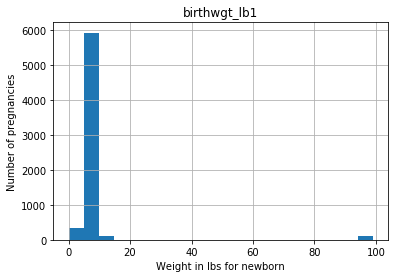

In [94]:
# Plot the histogram
nsfg.hist('birthwgt_lb1', bins=20)

# Label the axes
plt.xlabel('Weight in lbs for newborn')
plt.ylabel('Number of pregnancies')

# Show the figure
plt.show()

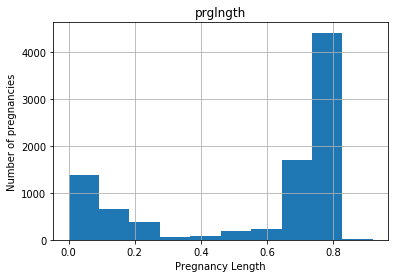

In [95]:
# Plot the histogram
nsfg.hist('prglngth')

# Label the axes
plt.xlabel('Pregnancy Length')
plt.ylabel('Number of pregnancies')

# Show the figure
plt.show()

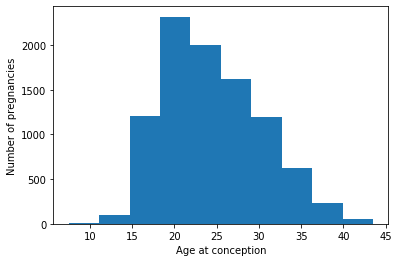

In [96]:
# Plot the histogram
plt.hist(nsfg['agecon'] / 100)

# Label the axes
plt.xlabel('Age at conception')
plt.ylabel('Number of pregnancies')

# Show the figure
plt.show()

## Statistics
Now let's pull together the steps to compute the average birth weight for full-term babies (`prglngth > 37`).

I've provided a function, `resample_rows_weighted`, that takes the NSFG data and resamples it using the sampling weights in `wgt2013_2015`. The result is a sample that is representative of the U.S. population.

In [97]:
def resample_rows_weighted(df, column, seed=13):
    """Resamples a DataFrame using probabilities proportional to given column.
    :param df: DataFrame
    :param column: string column name to use as weights
    :returns: DataFrame
    """
    np.random.seed(seed)
    weights = df[column] / sum(df[column])
    indices = np.random.choice(df.index, len(df), replace=True, p=weights)
    sample = df.loc[indices]
    return sample

In [98]:
# Resample the data
nsfg_sampled = resample_rows_weighted(nsfg, 'wgt2013_2015')

# Clean the weight variables
pounds = nsfg_sampled['birthwgt_lb1'].replace([98, 99], np.nan)
ounces = nsfg_sampled['birthwgt_oz1'].replace([98, 99], np.nan)

# Compute total birth weight
birth_weight = pounds + ounces/16

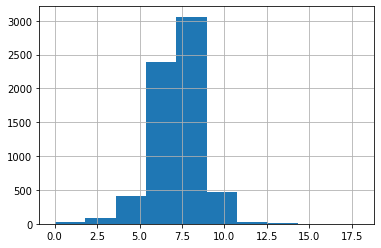

In [99]:
birth_weight.hist()

In [115]:
# Create a Boolean Series for full-term babies
full_term = nsfg_sampled['prglngth'] * 100 >= 37

# Select the weights of full-term babies
full_term_weight = birth_weight[full_term].dropna()

# Compute the mean weight of full-term babies
full_term_weight.mean()

7.206741898148148

In [116]:
# Create a Boolean Series for preterm babies
full_term = nsfg_sampled['prglngth'] * 100 < 37

# Select the weights of full-term babies
non_full_term_weight = birth_weight[full_term].dropna()

# Compute the mean weight of full-term babies
non_full_term_weight.mean()

4.0

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.

In [117]:
from scipy.stats import f_oneway

In [118]:
f_oneway(full_term_weight.values, non_full_term_weight.values)

F_onewayResult(statistic=5.601638824360151, pvalue=0.017972921071025882)

# Filter

The distribution of weight is also different for multiple births, like twins and triplets. In this exercise, you'll filter them out, too, and see what effect it has on the mean.

In [119]:
nsfg_sampled['birth_weight'] = birth_weight
nsfg_sampled[full_term_mask].groupby('nbrnaliv')['birth_weight'].mean().head()

Series([], Name: birth_weight, dtype: float64)

In [123]:
# Filter full-term babies
full_term_mask = nsfg_sampled['prglngth'] * 100 >= 37

# Filter single births
single_mask = nsfg_sampled['nbrnaliv'] == 1

# Compute birth weight for single full-term babies
single_full_term_weight = birth_weight[full_term_mask & single_mask].dropna()

print('Single full-term mean:', single_full_term_weight.mean())

Single full-term mean: 7.247485462831998


In [124]:
# Compute birth weight for multiple full-term babies
mult_full_term_weight = birth_weight[~single_mask & full_term_mask].dropna()

print('Multiple full-term mean:', mult_full_term_weight.mean())

Multiple full-term mean: 4.990918803418803


In [125]:
f_oneway(single_full_term_weight.values, mult_full_term_weight.values)

F_onewayResult(statistic=335.1694532025223, pvalue=4.876942156706812e-73)

# Probability mass functions

The **General Social Survey** (**GSS**) is a sociological survey created and regularly collected since 1972 by the National Opinion Research Center at the University of Chicago. It is funded by the National Science Foundation. The GSS collects information and keeps a historical record of the concerns, experiences, attitudes, and practices of residents of the United States.

- Annual sample of U.S. population
- Asks about demographics, social and political beliefs

In [126]:
import gc

gc.collect();

In [127]:
file = '../data/27. Análisis Exploratorio de Datos/gss.hdf5'
gss = h5_to_pd(file, 'gss')
gss.head()

,age,cohort,educ,realinc,gunlaw,grass,wtssall,year,sex,race
0,26.0,1946.0,18.0,13537.0,2.0,NaN,0.8893,1972,1,1
1,38.0,1934.0,12.0,18951.0,1.0,NaN,0.4446,1972,2,1
2,57.0,1915.0,12.0,30458.0,1.0,NaN,1.3339,1972,1,1
3,61.0,1911.0,14.0,37226.0,1.0,NaN,0.8893,1972,2,1
4,59.0,1913.0,12.0,30458.0,2.0,NaN,0.8893,1972,1,1


The distribution of income in almost every country is long-tailed; that is, there are a small number of people with very high incomes.

In the GSS dataset, the variable 'realinc' represents total household income, converted to 1986 dollars. We can get a sense of the shape of this distribution by plotting the CDF.

In probability theory and statistics, the ***cumulative distribution function (CDF)*** of a real-valued random variable ***X***, or just distribution function of ***X***, evaluated at x, is the probability that ***X*** will take a value less than or equal to x.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000026934456688>]],
      dtype=object)

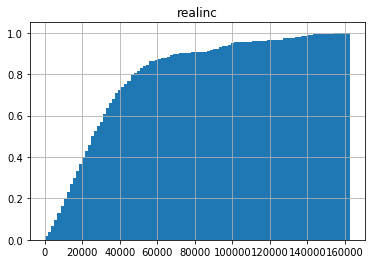

In [128]:
gss.hist('realinc', cumulative=True, density=1, bins=100)

# Distributions

Let's begin comparing incomes for different levels of education in the GSS dataset. The variable `educ` represents the respondent's years of education.

What fraction of respondents report that they have 12 years of education or fewer?

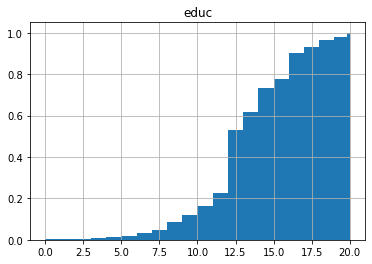

In [129]:
gss.hist('educ', cumulative=True, density=1, bins=100)
plt.show()

In the U.S, 12 years of education usually means the respondent has completed high school (secondary education). A respondent with 14 years of education has probably completed an associate degree (two years of college); someone with 16 years has probably completed a bachelor's degree (four years of college).

In [130]:
gss.groupby('educ')['realinc'].mean().reset_index().tail(10)

,educ,realinc
11,11.0,24559.914503
12,12.0,30265.888455
13,13.0,33526.841312
14,14.0,36918.908456
15,15.0,37683.367151
16,16.0,49576.572500
17,17.0,51157.571004
18,18.0,57480.893192
19,19.0,58796.273113
20,20.0,64833.451064


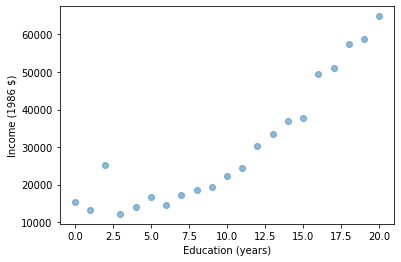

In [131]:
# Compute mean income in each group
mean_income_by_educ = gss.groupby('educ')['realinc'].mean()

# Plot mean income as a scatter plot
plt.clf()
plt.plot(mean_income_by_educ, 'o', alpha=0.5)

# Label the axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.show()

### Plot income CDFs
Let's now see what the distribution of income looks like for people with different education levels. You can do this by plotting the CDFs.

In [132]:
import seaborn as sns

In [133]:
# Bachelor's degree
mask_bach = gss.educ >= 16

# Associate degree
mask_assc = (gss.educ >= 14) & (gss.educ < 16)

# High school
mask_high = gss.educ <= 12

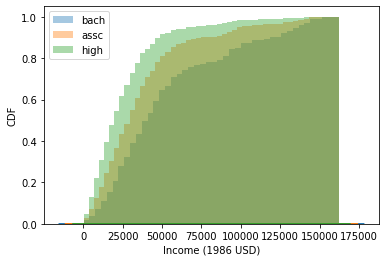

In [134]:
bach = gss.loc[mask_bach, ['realinc']].dropna()
assc = gss.loc[mask_assc, ['realinc']].dropna()
high = gss.loc[mask_high, ['realinc']].dropna()

kwargs = {'cumulative': True}

sns.distplot(bach, hist_kws=kwargs)
sns.distplot(assc, hist_kws=kwargs)
sns.distplot(high, hist_kws=kwargs)

plt.legend(labels=['bach','assc','high'])
plt.xlabel('Income (1986 USD)')
plt.ylabel('CDF')
plt.show()

### Distribution of income

In many datasets, the distribution of income is approximately lognormal, which means that the logarithms of the incomes fit a normal distribution. We'll see whether that's true for the GSS data. As a first step, you'll compute the mean and standard deviation of the log of incomes using NumPy's `np.log10()` function.

In [135]:
# Extract realinc and compute its log
income = gss['realinc']
log_income = np.log10(income)

# Compute mean and standard deviation
mean = log_income.mean()
std = log_income.std()
print(f'Mean of the log-income: {round(mean,2)}, with std of {round(std,4)}')

Mean of the log-income: 4.37, with std of 0.429


To see whether the distribution of income is well modeled by a lognormal distribution, we'll compare the CDF of the logarithm of the data to a normal distribution with the same mean and standard deviation. 

`dist` is a `scipy.stats.norm` object with the same mean and standard deviation as the data. It provides `.cdf()`, which evaluates the normal cumulative distribution function.

In [136]:
from scipy.stats import norm

C:\Users\vilieri.i\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vilieri.i\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


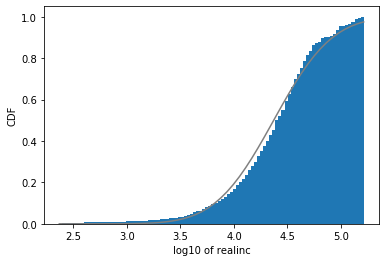

In [137]:
dist = norm(mean, std)

# Create a synthetic lognormal distribution
xs = np.linspace(log_income.min(), log_income.max())
ys = dist.cdf(xs)

# Plot the model CDF
plt.clf()
plt.plot(xs, ys, color='gray')

plt.hist(log_income, cumulative=True, density=1, bins=100)
    
# Label the axes
plt.xlabel('log10 of realinc')
plt.ylabel('CDF')
plt.show()

# Exploring relationships

The ***Behavioral Risk Factor Surveillance System*** (***BRFSS***) is the nation’s premier system of health-related telephone surveys that collect state data about U.S. residents regarding their health-related risk behaviors, chronic health conditions, and use of preventive services.

Do people tend to gain weight as they get older? We can answer this question by visualizing the relationship between weight and age.

In [138]:
gc.collect();

In [139]:
file = '../data/27. Análisis Exploratorio de Datos/brfss.hdf5'
brfss = h5_to_pd(file, 'brfss')
brfss.head()

Only 1 dimension..


,SEX,HTM4,WTKG3,INCOME2,_LLCPWT,_AGEG5YR,_VEGESU1,_HTMG10,AGE
0,2.0,160.0,60.33,8.0,1398.525290,6.0,2.14,150.0,47.0
1,2.0,163.0,58.97,5.0,84.057503,13.0,3.14,160.0,89.5
2,2.0,163.0,72.57,8.0,390.248599,5.0,2.64,160.0,42.0
3,2.0,165.0,74.84,1.0,11566.705300,3.0,1.46,160.0,32.0
4,2.0,170.0,108.86,3.0,844.485450,3.0,1.81,160.0,32.0


## Scatter plot
Now let's make a scatterplot of weight (`WTKG3`) versus age (`AGE`).

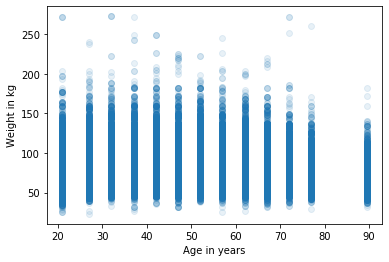

In [140]:
# Make a scatter plot
plt.plot(brfss['AGE'], brfss['WTKG3'], 'o', alpha=0.1)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')

plt.show()

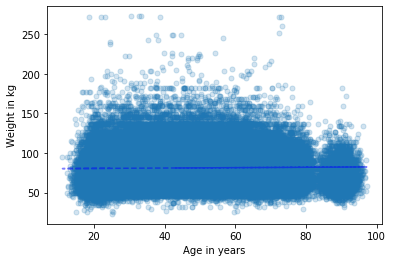

In [141]:
brfss_cleaned = brfss.dropna(subset=['AGE', 'WTKG3'])

# Add jittering to age
age = brfss_cleaned['AGE'] + np.random.normal(0, 2.5, size=len(brfss_cleaned))

# Extract weight
weight = brfss_cleaned['WTKG3']

# Make a scatter plot
plt.plot(age, weight, 'o', markersize=5, alpha=0.2)

# Trend line
z = np.polyfit(age, weight, 1)
p = np.poly1d(z)
plt.plot(age, p(age), "r--", color='blue', alpha=0.5)

plt.xlabel('Age in years')
plt.ylabel('Weight in kg')
plt.show()

## Height and weight
Let's take a closer look using a box plot. The brfss DataFrame contains a variable `_HTMG10` that represents height in centimeters, binned into 10 cm groups.

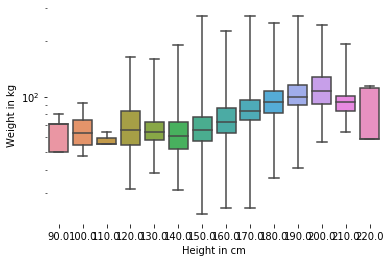

In [142]:
# Drop rows with missing data
data = brfss.dropna(subset=['_HTMG10', 'WTKG3'])

# Make a box plot
sns.boxplot(x='_HTMG10', y='WTKG3', data=data, whis=10)

# Plot the y-axis on a log scale
plt.yscale('log')

# Remove unneeded lines and label axes
sns.despine(left=True, bottom=True)
plt.xlabel('Height in cm')
plt.ylabel('Weight in kg')
plt.show()

## Distribution of income
In the next two exercises we'll look at relationships between income and other variables. In the BRFSS, income is represented as a categorical variable; that is, respondents are assigned to one of 8 income categories. The variable name is `INCOME2`.

C:\Users\vilieri.i\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\vilieri.i\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


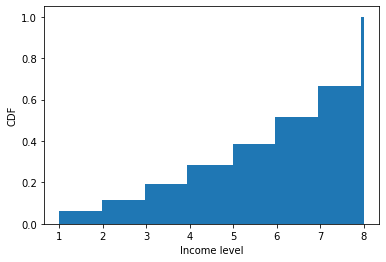

In [143]:
plt.hist(brfss['INCOME2'], cumulative=True, density=1, bins=100)
    
# Label the axes
plt.xlabel('Income level')
plt.ylabel('CDF')
plt.show()

## Income and height
Let's now use a violin plot to visualize the relationship between income and height.

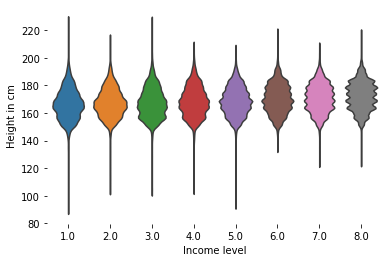

In [144]:
# Drop rows with missing data
data = brfss.dropna(subset=['INCOME2', 'HTM4'])

# Make a violin plot
sns.violinplot(x='INCOME2', y='HTM4', data=data, inner=None)

# Remove unneeded lines and label axes
sns.despine(left=True, bottom=True)
plt.xlabel('Income level')
plt.ylabel('Height in cm')
plt.show()

## Computing correlations

The purpose of the BRFSS is to explore health risk factors, so it includes questions about diet. The variable `_VEGESU1` represents the number of servings of vegetables respondents reported eating per day.

Let's see how this variable relates to age and income.

In [145]:
# Select columns
columns = ['AGE', 'INCOME2', '_VEGESU1']
subset = brfss[columns]

# Compute the correlation matrix
subset.corr()

,AGE,INCOME2,_VEGESU1
AGE,1.000000,-0.015158,-0.009834
INCOME2,-0.015158,1.000000,0.119670
_VEGESU1,-0.009834,0.119670,1.000000


# Linear Regression


### Income and vegetables
Let's estimate the slope of the relationship between vegetable consumption and income.

In [59]:
from sklearn import linear_model
from scipy.stats import linregress
from statsmodels.api import OLS, add_constant

In [146]:
subset = brfss.dropna(subset=['INCOME2', '_VEGESU1'])

x_train = subset[['INCOME2']]
y_train = subset[['_VEGESU1']]

In [147]:
# Create linear regression object using sklearn (x, y)
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(x_train.values.reshape(-1,1), y_train.values)

# Extract the variables
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[0.06988048]]


In [148]:
# Compute the linear regression using scipy (x, y)
res = linregress(x_train.INCOME2.values, y_train._VEGESU1.values)
res

LinregressResult(slope=0.06988048092105006, intercept=1.5287786243363113, rvalue=0.11967005884864092, pvalue=1.378503916249654e-238, stderr=0.0021109763563323305)

In [149]:
# Compute the linear regression using statsmodels (y, x)
x_train = x_train.INCOME2.values
x_train = add_constant(x_train)
OLS(y_train.values, x_train).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1096.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):          1.38e-238
Time:                        09:14:44   Log-Likelihood:            -1.2571e+05
No. Observations:               75426   AIC:                         2.514e+05
Df Residuals:                   75424   BIC:                         2.514e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5288      0.013    115.848      0.000       1.503       1.555
x1             0.0699      0.002     33.103      0.000       0.066       0.074
==============================================================================
Omnibus:                    44488.424   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           661077.351
Skew:                           2.568   Prob(JB):                         0.00
Kurtosis:                      16.563   Cond. No.                         18.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

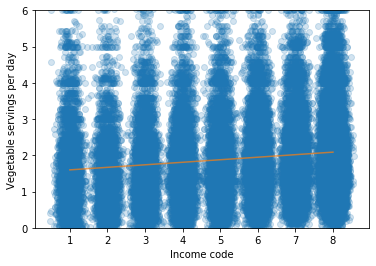

In [150]:
# Plot the scatter plot
plt.clf()
x_jitter = subset['INCOME2'] + np.random.normal(0, 0.15, len(subset['INCOME2']))
plt.plot(x_jitter, subset['_VEGESU1'], 'o', alpha=0.2)

# Plot the line of best fit
fx = np.array([subset['INCOME2'].min(), subset['INCOME2'].max()])
fy = res.intercept + res.slope * fx
plt.plot(fx, fy, '-', alpha=0.7)

plt.xlabel('Income code')
plt.ylabel('Vegetable servings per day')
plt.ylim([0, 6])
plt.show()

## Regression and causation

In the BRFSS dataset, there is a strong relationship between vegetable consumption and income. The income of people who eat 8 servings of vegetables per day is double the income of people who eat none, on average.

Which of the following conclusions can we draw from this data?

- Eating a good diet leads to better health and higher income.

- People with higher income can afford a better diet.

- People with high income are more likely to be vegetarians.

In [80]:
import statsmodels.formula.api as smf

In [151]:
# Run regression with statsmodels formula
results = smf.ols('_VEGESU1 ~ INCOME2', data=brfss).fit()
results.params

Intercept    1.528779
INCOME2      0.069880
dtype: float64

## Multiple regression

### Non-linear model of education
If you remember the GSS data, we saw that it might be a relationship between income and education, but it might be non-linear. So let's try fitting a non-linear model.

In [172]:
gss.head()

,age,cohort,educ,realinc,gunlaw,grass,wtssall,year,sex,race,educ2,age2
0,26.0,1946.0,18.0,13537.0,2.0,NaN,0.8893,1972,1,1,324.0,676.0
1,38.0,1934.0,12.0,18951.0,1.0,NaN,0.4446,1972,2,1,144.0,1444.0
2,57.0,1915.0,12.0,30458.0,1.0,NaN,1.3339,1972,1,1,144.0,3249.0
3,61.0,1911.0,14.0,37226.0,1.0,NaN,0.8893,1972,2,1,196.0,3721.0
4,59.0,1913.0,12.0,30458.0,2.0,NaN,0.8893,1972,1,1,144.0,3481.0


In [154]:
# Add a new column with educ squared
gss['educ2'] = gss['educ']**2

gss['age2'] = gss['age']**2

# Run a regression model with educ, educ2, age, and age2
results = smf.ols('realinc ~ educ + educ2 + age + age2', data=gss).fit()

# Print the estimated parameters
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                realinc   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     2792.
Date:                Thu, 24 Sep 2020   Prob (F-statistic):               0.00
Time:                        09:17:06   Log-Likelihood:            -6.4520e+05
No. Observations:               55345   AIC:                         1.290e+06
Df Residuals:                   55340   BIC:                         1.290e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.324e+04   1501.499    -15.479      0.000   -2.62e+04   -2.03e+04
educ        -528.3094    186.045     -2.840      0.005    -892.958    -163.661
educ2        159.9667      7.327     21.834      0.000     145.607     174.327
age         1696.7171     39.319     43.153      0.000    1619.652    1773.782
age2         -17.1970      0.404    -42.538      0.000     -17.989     -16.405
==============================================================================
Omnibus:                    17422.378   Durbin-Watson:                   1.978
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            51721.770
Skew:                           1.657   Prob(JB):                         0.00
Kurtosis:                       6.382   Cond. No.                     3.50e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Making predictions
At this point, we have a model that predicts income using age, education, and sex.

Let's see what it predicts for different levels of education, holding age constant.

In [167]:
# Make the DataFrame
df = pd.DataFrame()
df['educ'] = np.linspace(0, 20)
df['age'] = 30
df['educ2'] = df['educ']**2
df['age2'] = df['age']**2
df.tail()

,educ,age,educ2,age2
45,18.367347,30,337.359434,900
46,18.775510,30,352.519783,900
47,19.183673,30,368.013328,900
48,19.591837,30,383.840067,900
49,20.000000,30,400.000000,900


In [168]:
# Generate and plot the predictions
pred = results.predict(df).reset_index()
pred.tail()

,index,0
45,45,56444.992238
46,46,58654.507502
47,47,60917.322803
48,48,63233.438143
49,49,65602.853521


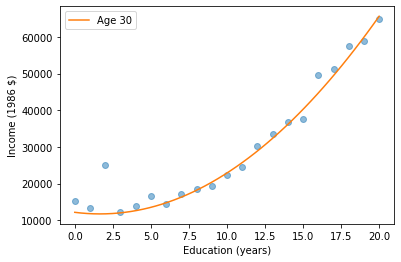

In [170]:
# Plot mean income in each age group
mean_income_by_educ = gss.groupby('educ')['realinc'].mean()

plt.clf()
plt.plot(mean_income_by_educ, 'o', alpha=0.5)

# Plot the predictions
pred = results.predict(df)
plt.plot(df['educ'], pred, label='Age 30')

# Label axes
plt.xlabel('Education (years)')
plt.ylabel('Income (1986 $)')
plt.legend()
plt.show()

## Predicting a binary variable

In the GSS dataset, the variable `grass` records the answer to the question "Do you think the use of marijuana should be made legal or not?"

In [185]:
gss.head()

,age,cohort,educ,realinc,gunlaw,grass,wtssall,year,sex,race,educ2,age2
0,26.0,1946.0,18.0,13537.0,2.0,NaN,0.8893,1972,1,1,324.0,676.0
1,38.0,1934.0,12.0,18951.0,1.0,NaN,0.4446,1972,2,1,144.0,1444.0
2,57.0,1915.0,12.0,30458.0,1.0,NaN,1.3339,1972,1,1,144.0,3249.0
3,61.0,1911.0,14.0,37226.0,1.0,NaN,0.8893,1972,2,1,196.0,3721.0
4,59.0,1913.0,12.0,30458.0,2.0,NaN,0.8893,1972,1,1,144.0,3481.0


In [186]:
gss['grass'].describe()

count    36222.000000
mean         0.304428
std          0.460171
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: grass, dtype: float64

Let's use logistic regression to predict a binary variable. Specifically, we'll use age, sex, and education level to predict support for legalizing cannabis (marijuana) in the U.S.

In [188]:
# Recode grass
gss['grass'].replace(2, 0, inplace=True)

# Run logistic regression
results = smf.logit('grass ~ age + age2 + educ + educ2 + C(sex)', data=gss).fit()
results.params.reset_index()

Optimization terminated successfully.
         Current function value: 0.588510
         Iterations 6


,index,0
0,Intercept,-1.685223
1,C(sex)[T.2],-0.384611
2,age,-0.034756
3,age2,0.000192
4,educ,0.221860
5,educ2,-0.004163


La regresión logística unidimensional puede usarse para tratar de correlacionar la probabilidad de una variable cualitativa binaria (asumiremos que puede tomar los valores reales "0" y "1") con una variable escalar x. La idea es que la regresión logística aproxime la probabilidad de obtener "0" (no ocurre cierto suceso) o "1" (ocurre el suceso) con el valor de la variable explicativa x. En esas condiciones, la probabilidad aproximada del suceso se aproximará mediante una función logística del tipo:

\begin{equation*} 
y={\frac {1}{1+e^{-f(X)}}}
\end{equation*}

In [189]:
# Make a DataFrame with a range of ages
df = pd.DataFrame()
df['age'] = np.linspace(18, 89)
df['age2'] = df['age']**2

# Set the education level to 12
df['educ'] = 12
df['educ2'] = df['educ']**2

df.head()

,age,age2,educ,educ2
0,18.000000,324.000000,12,144
1,19.448980,378.262807,12,144
2,20.897959,436.724698,12,144
3,22.346939,499.385673,12,144
4,23.795918,566.245731,12,144


In [194]:
# Generate predictions for men 
df['sex'] = 1
pred1 = results.predict(df)
pred1.reset_index().head()

,index,0
0,0,0.453667
1,1,0.443782
2,2,0.434139
3,3,0.424743
4,4,0.415596


In [195]:
# Generate predictions for women
df['sex'] = 2
pred2 = results.predict(df)
pred2.reset_index().head()

,index,0
0,0,0.361127
1,1,0.351959
2,2,0.343081
3,3,0.334491
4,4,0.326185


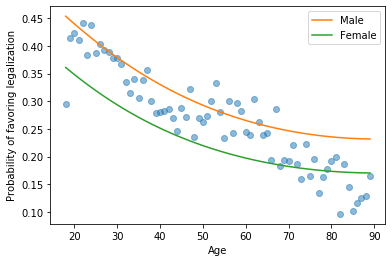

In [196]:
# Finally lets plot it
favor_by_age = gss.groupby('age')['grass'].mean()

plt.clf()
plt.plot(favor_by_age, 'o', alpha=0.5)

plt.plot(df['age'], pred1, label='Male')
plt.plot(df['age'], pred2, label='Female')

plt.xlabel('Age')
plt.ylabel('Probability of favoring legalization')
plt.legend()
plt.show()